# PaperTrade

This notebook applies the generated Buy/Sell signals to DepotManager.

1. Notebook loads `MACD_BuySell_<par1>_<par2>_<par3>.ipynb`
1. Use papermill module to extract the data file `MACD_BuySell_<stock data file>_<par1>_<par2>_<par3>.csv` from the notebook.
1. Load the csv data
1. Run buy/sell data against DepotManager

In [1]:
# notebook name, where the 
nb_file = '../data/interim/MACD_BuySell_12_26_9.ipynb'

# initial balance of the depot 
balance = 2000


#### Some installs and imports

In [2]:
# Install a pip module in the current Jupyter kernel
import sys

try:   
    import seaborn as sns
except ImportError as err:
    print("Handling run-time error: ", err)
    print("Will now install missing module.")
    !{sys.executable} -m pip install seaborn
    
try:
    import papermill as pm
except ImportError as err:
    print("Handling run-time error: ", err)
    print("Will now install missing module.")
    !{sys.executable} -m pip install papermill


In [3]:
# other imports
import os
import math

# manipulating data
import pandas as pd
import numpy as np
#from stockstats import StockDataFrame as Sdf

# plotting
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
import matplotlib.style as style 

# notebook parameterizing and automation 
import papermill as pm

## Load Buy/Sell Signals from a Notebook

Use papermill to load the notebook `nb_file`and extract the csv file location containing buy/sell signals. Finally, it loads the csv file into a dataframe. 

In [4]:
# load the notebook and extract the csv file location
nb = pm.read_notebook(nb_file)

# extract csv file location 
output_data_path = nb.dataframe[nb.dataframe['name']=='output_data_path']['value'].values[0]
csv = nb.dataframe[nb.dataframe['name']=='csv']['value'].values[0]
csv_file = os.path.join(output_data_path, csv )

In [5]:
stock = pd.read_csv(csv_file, delimiter=';', header=0)
stock.drop(['Unnamed: 0'], axis=1, inplace=True)

## Simulate Trading

Utilizes DepotManager module to simulate trading using the stock data and the buy/sell signals. Trading uses best/worst/open stock prices at day t for the buy/sell signal at day t-1.

In [6]:
# import DepotManager

module_path = os.path.abspath(os.path.join(os.getcwd(),'../src/DepotManager'))
if module_path not in sys.path:
    sys.path.append(module_path)

import DepotManager as dp

In [7]:
#
# Paper trades the stocks using an initial balance and price mode
#

def papertrade(df, stock, bal=balance, mode='open'):
    """ Paper trading the stock.

    This function checks the buy/sell signal of day t-1
    and trades the stock at day t using best/worst/open price.
    Finally, it adds a new column to dataframe df named balance_<mode>.
    
    :param df: data
    :param stock: stock name
    :param bal: initial balance
    :param mode: decides what price to use for buy/sell
    
    mode: 
        open: always use the open price of the current business day for buy and sell
        close: always use the close price of the current business day for buy and sell
        best: use the current day's low price for buy; current day's high price for sell
        worst: use the current day's high price for buy; current day's low price for sell
        
    
    :return: None
    """

    # instanciate the DepotManager and built a new depot
    dpMngr = dp.DepotManager()
    dpWKN = dpMngr.buildDepot(stock + '_' + mode)
    # charge up with balance
    dpWKN.broker.balance = bal
    
    # correct order of data
    df.sort_index(ascending=True)
    # initialize col
    bal_col = 'balance_' + mode
    df[bal_col] = math.nan
    df.at[0, bal_col]=dpWKN.broker.balance

    for i in range(1, len(df)):

        avail_balance = dpWKN.broker.balance - 30
        avail_shares = dpWKN.totalStockinDepot()
        date = df.at[i, 'date']

        # buy
        if df.at[i-1, 'signal'] == 1:
            #print('buy')
            if mode == 'open':
                price = df.at[i, 'open']
            if mode == 'close':
                price = df.at[i, 'close']
            if mode == 'best':
                price = df.at[i, 'low']
            if mode == 'worst':
                price = df.at[i, 'high']
                
            shares = math.floor(avail_balance/price)
            dpWKN.buy(date, shares, price )

        # sell
        if df.at[i-1, 'signal'] == -1:
            #print('sell')
            if mode == 'open':
                price = df.at[i, 'open']
            if mode == 'close':
                price = df.at[i, 'close']
            if mode == 'best':
                price = df.at[i, 'high']
            if mode == 'worst':
                price = df.at[i, 'low']

            dpWKN.sell(date, avail_shares, price )

        # hold
        #if df.at[i, 'signal'] == 0:
            #print('hold')
            # nothing to do here

        # Store the final balance in stock frame
        df.at[i, bal_col] = dpWKN.broker.balance
        

In [8]:
# Run paper trade through all modes
for mode in ['open', 'close', 'best', 'worst'] :
    papertrade(df=stock, stock='840400', bal=balance, mode=mode)

## Visualize Results

Plot of closing price, the buy/sell signals and the available balance according to the various modi, e.g. open, close, best, worst.

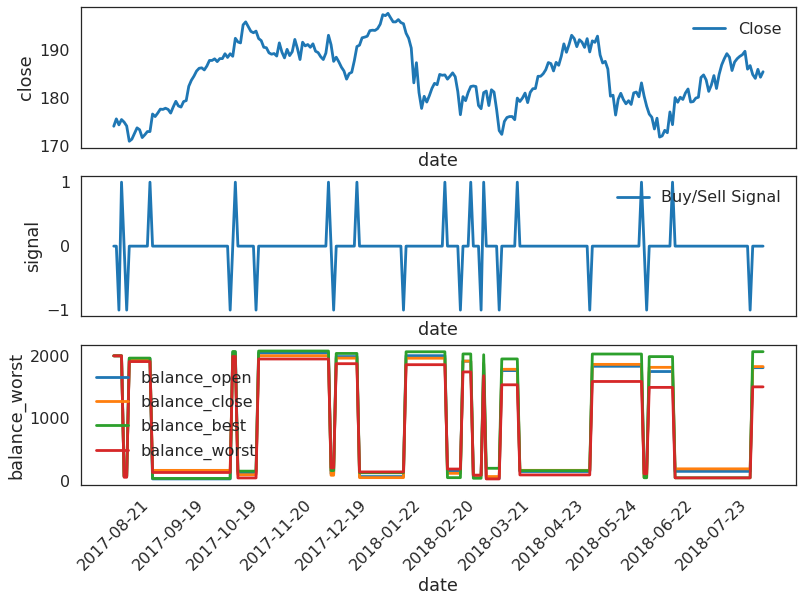

In [9]:
# set plot style
style.use('seaborn-poster')
style.use('seaborn-white')

# Create a figure instance, and the two subplots
fig = plt.figure()
ax1 = fig.add_subplot(311) # 3x1, fig.1
ax2 = fig.add_subplot(312) # 3x1, fig.2
ax3 = fig.add_subplot(313) # 3x1, fig.3

# Stock data
sns.lineplot(data=stock, x='date', y='close', label='Close', ax=ax1)
# Buy/Sell Signal
sns.lineplot(data=stock, x='date', y='signal', label='Buy/Sell Signal', ax=ax2)
# Balance 
sns.lineplot(data=stock, x='date', y='balance_open', label='balance_open', markers=True, dashes=False, ax=ax3)
sns.lineplot(data=stock, x='date', y='balance_close', label='balance_close', markers=True, dashes=False, ax=ax3)
sns.lineplot(data=stock, x='date', y='balance_best', label='balance_best', markers=True, dashes=False, ax=ax3)
sns.lineplot(data=stock, x='date', y='balance_worst', label='balance_worst', markers=True, dashes=False, ax=ax3)


# remove ticks and labels 
ax1.tick_params(labelbottom=False, bottom=False)
ax2.tick_params(labelbottom=False, bottom=False)   

# format ticks
l=stock.date.count()/12
plt.xticks(stock.date[0::int(l)], rotation=45)
plt.show()

## Some Stats

In [11]:
STATS = stock.describe()
print(STATS)

             open        high         low       close        shares  \
count  252.000000  252.000000  252.000000  252.000000  2.520000e+02   
mean   184.629700  185.828262  183.221285  184.497138  1.323365e+06   
std      6.438659    6.375852    6.556162    6.482004  5.376838e+05   
min    171.073400  172.897400  169.057400  170.929400  6.302010e+05   
25%    179.698575  181.010000  178.225500  179.375100  1.015912e+06   
50%    185.070300  186.094400  183.720000  184.810350  1.212792e+06   
75%    189.457200  191.262400  188.365600  189.436000  1.436933e+06   
max    197.953600  198.577700  196.753600  197.521600  4.478718e+06   

             volume  close_12_ema  close_26_ema        macd       macds  \
count  2.520000e+02    252.000000    252.000000  252.000000  252.000000   
mean   2.438393e+08    184.247229    184.007997    0.239232    0.217932   
std    9.737240e+07      5.889254      5.303585    1.775688    1.620324   
min    1.098735e+08    172.884507    173.101244   -3.318409 

In [14]:
stock['balance_best'].max()

2077.181816

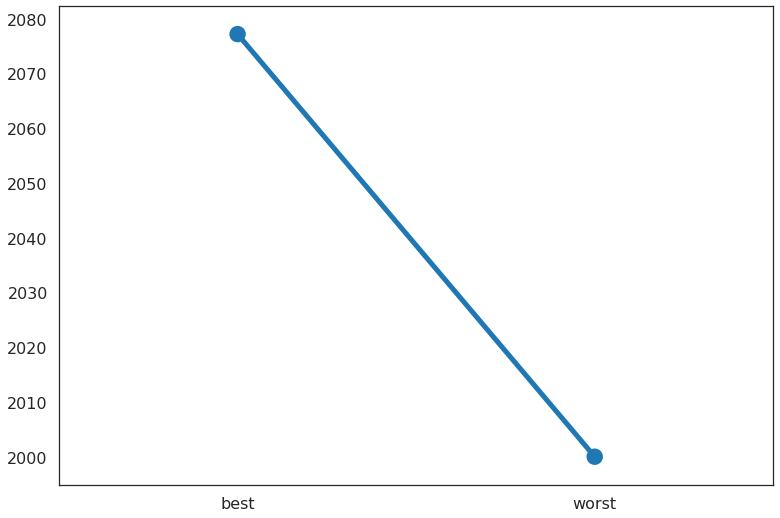

In [22]:
sns.pointplot(x=['best', 'worst'], y=[stock['balance_best'].max(), stock['balance_worst'].max() ])

In [20]:
help pointplot

SyntaxError: invalid syntax (<ipython-input-20-b2536ed07996>, line 1)